It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ezponda/intro_deep_learning/blob/main/class/NLP/Embedding_layer.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/ezponda/intro_deep_learning/blob/main/class/NLP/Embedding_layer.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

In [1]:
import pathlib
import os
import sklearn
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd

## Embedding layer

Take a look at the documentation of the [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

The Embedding layer can be understood as a lookup table that maps from integer indices  to dense vectors (their embeddings). 

```python
tf.keras.layers.Embedding(
    input_dim, output_dim, input_length=None
)
```

- **input_dim**	Integer. Number of different categories (size of the vocabulary, number of films..) , i.e. maximum integer index + 1.
- **output_dim** Integer. Dimension of the dense embedding.
- **input_length** Length of input sequences, It is not necessary if you are not using sequences.

In [2]:
embedding_layer = tf.keras.layers.Embedding(input_dim=100, output_dim=5, input_length=None)

In [3]:
vector_ind_0 = embedding_layer(tf.constant([0]))
vector_ind_1 = embedding_layer(tf.constant([1]))
vector_ind_2 = embedding_layer(tf.constant([2]))

print(vector_ind_0.shape)
print('Embedding of entity with index 0: ', vector_ind_0.numpy().flatten())
print('Embedding of entity with index 1: ', vector_ind_1.numpy().flatten())
print('Embedding of entity with index 2: ', vector_ind_2.numpy().flatten())

(1, 5)
Embedding of entity with index 0:  [-0.02853979 -0.04507134  0.04420176  0.00676606  0.02127688]
Embedding of entity with index 1:  [0.02633605 0.03937704 0.00567242 0.00490309 0.01056782]
Embedding of entity with index 2:  [-0.02775916  0.00378073  0.01808531 -0.0391494  -0.03688826]


In [4]:
input_sequence = [0, 1, 2, 1]
print('input sequence', input_sequence)
sequence = embedding_layer(tf.constant(input_sequence))
print('sequence embeddings shape', sequence.shape)
print('sequence embeddings', sequence.numpy())

input sequence [0, 1, 2, 1]
sequence embeddings shape (4, 5)
sequence embeddings [[-0.02853979 -0.04507134  0.04420176  0.00676606  0.02127688]
 [ 0.02633605  0.03937704  0.00567242  0.00490309  0.01056782]
 [-0.02775916  0.00378073  0.01808531 -0.0391494  -0.03688826]
 [ 0.02633605  0.03937704  0.00567242  0.00490309  0.01056782]]


# Applications: Recommender System

We are going too use the [MovieLens 100K dataset](https://grouplens.org/datasets/movielens/100k/). We can create model to recommend movies for a given user.

In [5]:
dataset_url = 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip' # small
data_dir = tf.keras.utils.get_file('movielens_small', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir)
data_dir = data_dir.parent / 'ml-latest-small'
os.listdir(data_dir)

['links.csv', 'tags.csv', 'ratings.csv', 'README.txt', 'movies.csv']

In [6]:
ratings_file = data_dir / "ratings.csv"
df_ratings = pd.read_csv(ratings_file)
df_ratings = sklearn.utils.shuffle(df_ratings)
df_ratings.head()

,userId,movieId,rating,timestamp
97918,606,3655,3.5,1171361462
11030,68,4969,3.0,1267237921
19416,125,80549,3.5,1474569979
26621,182,3354,0.5,1075859296
47862,309,1301,4.0,1126453993


In [7]:
## ratings  
from collections import Counter
print(Counter(df_ratings['rating']))

Counter({4.0: 26818, 3.0: 20047, 5.0: 13211, 3.5: 13136, 4.5: 8551, 2.0: 7551, 2.5: 5550, 1.0: 2811, 1.5: 1791, 0.5: 1370})


In [8]:
# Create a user index
user_ids = sorted(list(df_ratings["userId"].unique()))
user2index = {u: ind for ind, u in enumerate(user_ids)}
index2user = {ind: u for u, ind in user2index.items()}
print(list(user2index.items())[:3])

[(1, 0), (2, 1), (3, 2)]


In [9]:
# Create a movie index
movie_ids = sorted(list(df_ratings["movieId"].unique()))
movie2index = {m: ind for ind, m in enumerate(movie_ids)}
index2movie = {ind: m for m, ind in movie2index.items()}
print(list(movie2index.items())[-2:])

[(193587, 9722), (193609, 9723)]


In [10]:
df_ratings["user"] = df_ratings["userId"].apply(lambda user_id: user2index[user_id])
df_ratings["movie"] = df_ratings["movieId"].apply(lambda movie_id: movie2index[movie_id])

In [11]:
num_users, num_movies = (len(user2index), len(movie2index))
print("Number of users: {0} \nNumber of Movies: {1}".format(
    num_users, num_movies))

Number of users: 610 
Number of Movies: 9724


In [12]:
movies_file = data_dir / "movies.csv"
df_movies = pd.read_csv(movies_file)
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
movie2title_genres = {}
for _, row in df_movies.iterrows():
    movie_id = row['movieId']
    if movie_id not in movie2index:
        continue
    movie = movie2index[movie_id]
    movie2title_genres[movie] = (row['title'], row['genres'])
print(list(movie2title_genres.items())[:3])
print(list(movie2title_genres.items())[-2:])

[(0, ('Toy Story (1995)', 'Adventure|Animation|Children|Comedy|Fantasy')), (1, ('Jumanji (1995)', 'Adventure|Children|Fantasy')), (2, ('Grumpier Old Men (1995)', 'Comedy|Romance'))]
[(9722, ('Bungo Stray Dogs: Dead Apple (2018)', 'Action|Animation')), (9723, ('Andrew Dice Clay: Dice Rules (1991)', 'Comedy'))]


### Create the model

In [14]:
embedding_size = 5

In [15]:
inputs = tf.keras.Input(shape=(2, ), name='user_input')

## user embeddings
user_input = inputs[:, 0]
user_embedding = layers.Embedding(num_users,
                                  embedding_size,
                                  name='user_embedding')(user_input)

## movie embeddings
movie_input = inputs[:, 1]
movie_embedding = layers.Embedding(num_movies,
                                   embedding_size,
                                   name='movie_embedding')(movie_input)

## Concat embeddings
concat = tf.concat([user_embedding, movie_embedding], axis=1)

## Predict Rating
layer_1 = layers.Dense(64, activation="relu", name='layer_1')(concat)

## Predict rating
outputs = layers.Dense(1, activation='sigmoid', name='output')(layer_1)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='movie')

model.summary()

Model: "movie"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 2)]          0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None,)              0           user_input[0][0]                 
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None,)              0           user_input[0][0]                 
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 5)            3050        tf.__operators__.getitem[0][0]   
______________________________________________________________________________________________

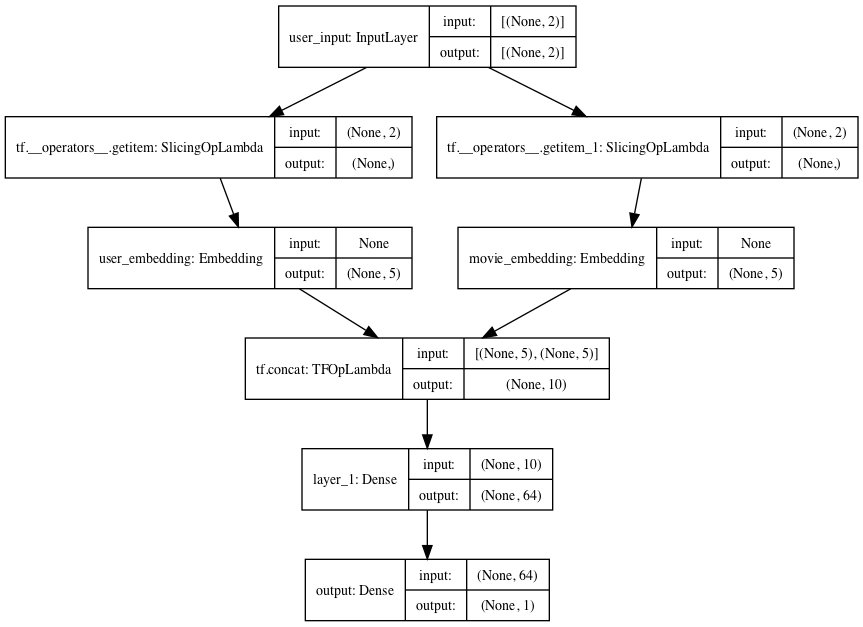

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [17]:
#df = df.sample(frac=1, random_state=42)
x = df_ratings[["user", "movie"]].values
# Normalize the targets between 0 and 1
y = df_ratings["rating"].values  / 5.0 

model.compile(
    loss='BinaryCrossentropy', optimizer='adam'
)
history = model.fit(
    x=x,
    y=y,
    batch_size=64,
    epochs=4,
    verbose=1,
    validation_split=0.2,
)

Epoch 1/4
1261/1261 [==============================] - 3s 2ms/step - loss: 0.6059 - val_loss: 0.5795
Epoch 2/4
1261/1261 [==============================] - 2s 1ms/step - loss: 0.5729 - val_loss: 0.5779
Epoch 3/4
1261/1261 [==============================] - 2s 1ms/step - loss: 0.5687 - val_loss: 0.5770
Epoch 4/4
1261/1261 [==============================] - 2s 1ms/step - loss: 0.5661 - val_loss: 0.5769


### Show recommendations

In [18]:
def show_recommendations(user,
                         model,
                         df_ratings,
                         movie2title_genres,
                         n_movies=10):

    total_movies = set(df_ratings['movie'].unique())
    df_user = df_ratings[df_ratings.user == user].copy()
    df_user = df_user.sort_values(by="rating", ascending=False)
    movies_watched = set(list(df_user['movie'].values))
    movies_unwatched = sorted(total_movies - movies_watched)
    top_movies = df_user[['movie', 'rating']].head(5)

    print("Movies with high ratings from user {0}".format(user))
    print('-' * 50)
    for _, row in top_movies.iterrows():
        title, genres = movie2title_genres[row['movie']]
        rating = row['rating']
        print('Movie: {0} | Rating: {1}, Genres: {2}'.format(
            title, rating, genres))

    print()
    print("Movies with low ratings from user {0}".format(user))
    print('-' * 50)
    for _, row in df_user[['movie', 'rating']].tail(5).iterrows():
        title, genres = movie2title_genres[row['movie']]
        rating = row['rating']
        print('Movie: {0} | Rating: {1}, Genres: {2}'.format(
            title, rating, genres))

    movies_array = np.array(movies_unwatched)
    user_array = np.array([user] * len(movies_array))
    x = np.vstack([user_array, movies_array]).T

    ratings = model.predict(x).flatten()
    movie_ratings = [(movies_array[i],ratings[i]) for i in np.argsort(-ratings)[:n_movies]]
    
    print()
    print("Movies recommended to user {0}".format(user))
    print('-' * 50)
    for movie, rating in movie_ratings:
        title, genres = movie2title_genres[movie]
        rating = rating * 5
        print('Movie: {0} | Rating pred: {1:.1f}, Genres: {2}'.format(
            title, rating, genres))
        
    
    movie_ratings = [(movies_array[i],ratings[i]) for i in np.argsort(ratings)[:3]]
    print()
    print("Movies NOT recommended to user {0}".format(user))
    print('-' * 50)
    for movie, rating in movie_ratings:
        title, genres = movie2title_genres[movie]
        rating = rating * 5
        print('Movie: {0} | Rating pred: {1:.1f}, Genres: {2}'.format(
            title, rating, genres))
    
    
    return

In [19]:
unique_users = df_ratings['user'].unique()
user = np.random.choice(unique_users)
show_recommendations(user, model, df_ratings, movie2title_genres, n_movies=10)

Movies with high ratings from user 602
--------------------------------------------------
Movie: Double Life of Veronique, The (Double Vie de Véronique, La) (1991) | Rating: 5.0, Genres: Drama|Fantasy|Romance
Movie: Rebel Without a Cause (1955) | Rating: 5.0, Genres: Drama
Movie: Memento (2000) | Rating: 5.0, Genres: Mystery|Thriller
Movie: Maltese Falcon, The (1941) | Rating: 5.0, Genres: Film-Noir|Mystery
Movie: Pulp Fiction (1994) | Rating: 5.0, Genres: Comedy|Crime|Drama|Thriller

Movies with low ratings from user 602
--------------------------------------------------
Movie: Last Action Hero (1993) | Rating: 1.0, Genres: Action|Adventure|Comedy|Fantasy
Movie: Source, The (1999) | Rating: 1.0, Genres: Documentary
Movie: Beach, The (2000) | Rating: 1.0, Genres: Adventure|Drama
Movie: Lethal Weapon 2 (1989) | Rating: 1.0, Genres: Action|Comedy|Crime|Drama
Movie: I Love Trouble (1994) | Rating: 1.0, Genres: Action|Comedy

Movies recommended to user 602
---------------------------------

## Question 1: Change the embeddings dimensions and add more complexity to the model

In [20]:
user_embedding_size = ...
movie_embedding_size = ...

In [21]:
inputs = tf.keras.Input(shape=(2, ), name='user_input')

## user embeddings
user_input = inputs[:, 0]
user_embedding = layers.Embedding(num_users,
                                  ...,
                                  name='user_embedding')(user_input)

## movie embeddings
movie_input = inputs[:, 1]
movie_embedding = layers.Embedding(num_movies,
                                   ...,
                                   name='movie_embedding')(movie_input)

## Concat embeddings
concat = tf.concat([user_embedding, movie_embedding], axis=1)

## Predict Rating
layer_1 = ...(concat)

## Predict rating
outputs = layers.Dense(1, activation='sigmoid', name='output')(layer_1)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='movie')


<>:19: SyntaxWarning: 'ellipsis' object is not callable; perhaps you missed a comma?
<>:19: SyntaxWarning: 'ellipsis' object is not callable; perhaps you missed a comma?


TypeError: '<=' not supported between instances of 'ellipsis' and 'int'

In [ ]:
model.compile(
    loss='BinaryCrossentropy', optimizer='adam'
)
history = model.fit(
    x=x,
    y=y,
    batch_size=64,
    epochs=4,
    verbose=1,
    validation_split=0.2,
)

In [ ]:
unique_users = df_ratings['user'].unique()
user = np.random.choice(unique_users)
show_recommendations(user, model, df_ratings, movie2title_genres, n_movies=10)

## Bigger Dataset


In [ ]:
dataset_url = 'http://files.grouplens.org/datasets/movielens/ml-latest.zip'
data_dir = tf.keras.utils.get_file('movielens', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir)
data_dir = data_dir.parent / 'ml-latest'
os.listdir(data_dir)

In [ ]:
movies_file = data_dir / "movies.csv"
ratings_file = data_dir / "ratings.csv"

### Data Preparation

In [ ]:
def prepare_data(ratings_file, movies_file, nrows=750000):

    df_ratings = pd.read_csv(ratings_file, nrows=nrows)
    df_ratings = sklearn.utils.shuffle(df_ratings)

    # Create a user index
    user_ids = sorted(list(df_ratings["userId"].unique()))
    user2index = {u: ind for ind, u in enumerate(user_ids)}
    index2user = {ind: u for u, ind in user2index.items()}
    # Create a movie index
    movie_ids = sorted(list(df_ratings["movieId"].unique()))
    movie2index = {m: ind for ind, m in enumerate(movie_ids)}
    index2movie = {ind: m for m, ind in movie2index.items()}
    # Change ids
    df_ratings["user"] = df_ratings["userId"].apply(
        lambda user_id: user2index[user_id])
    df_ratings["movie"] = df_ratings["movieId"].apply(
        lambda movie_id: movie2index[movie_id])

    num_users, num_movies = (len(user2index), len(movie2index))
    print("Number of users: {0} \nNumber of Movies: {1}".format(
        num_users, num_movies))

    df_movies = pd.read_csv(movies_file)
    movie2title_genres = {}
    for _, row in df_movies.iterrows():
        movie_id = row['movieId']
        if movie_id not in movie2index:
            continue
        movie = movie2index[movie_id]
        movie2title_genres[movie] = (row['title'], row['genres'])

    return df_ratings, movie2title_genres, num_users, num_movies

df_ratings, movie2title_genres, num_users, num_movies = prepare_data(ratings_file, movies_file)
print(len(df_ratings))

### Question 2: Obtain a better model and compare the number of parameter

In [ ]:
embedding_size = ...
inputs = tf.keras.Input(shape=(2, ), name='user_input')

## user embeddings
user_input = inputs[:, 0]
user_embedding = layers.Embedding(
    num_users,
    ...,
)(user_input)

## movie embeddings
movie_input = inputs[:, 1]
movie_embedding = layers.Embedding(num_movies, ...)(movie_input)

## Concat embeddings
concat = tf.concat([user_embedding, movie_embedding], axis=1)

## Predict Rating
layer_1 = ...
## Predict rating
outputs = layers.Dense(1, activation='sigmoid', name='output')(...)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='movie')

model.summary()

In [ ]:
x = df_ratings[["user", "movie"]].values
# Normalize the targets between 0 and 1
y = df_ratings["rating"].values  / 5.0 
model.compile(
    loss='BinaryCrossentropy', optimizer='adam'
)
history = model.fit(
    x,
    y,
    validation_split= 0.1,
    epochs=5,
    verbose=1,
    batch_size=512,
    shuffle=True
)


In [ ]:
unique_users = df_ratings['user'].unique()
user = np.random.choice(unique_users)
show_recommendations(user, model, df_ratings, movie2title_genres, n_movies=10)